In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def build_connections(M, N, w=1):
    """ To build a connection matrix
        
        Parameters
        ----------
        M: int
            row size
        N: int
            col size
        w: scalar
            weight
            
        Returns
        ----------
        a: np.ndarray
            connection matrix
    """
    T = False
    if M < N:
        T = True
        M, N = N, M
        
    pad = M // N
    a = np.zeros((M, N))
    
    for i in range(M):
        indices = np.arange(i - pad, i + pad + 1)
        larger = np.argwhere(indices >= N)
        indices[larger] = indices[larger] % N
        
        a[i, indices] = w # np.random.rand(indices.shape[0])
    if T:
        a = a.T
    return a

In [3]:
g_size = 10 # number of granule cells
m_size = 10 # number of mitral cells
assert g_size >= m_size

L = np.zeros((m_size, m_size)) # inter-mitral connections
for i in range(m_size):
    L[i, (i + 1) % m_size] = 1
    L[i, i - 1] = 1

t_max = 300
t_changing = [20, 50, 100]

tau = 2
# 1 / time const
a_x = 1 / tau
a_y = 1 / tau

I_c = 0.1 # central input
th = 1 # threshold

# activation function parameters
sx = 1.4
sy = 2.9

# helper step function
P = lambda a: np.piecewise(a, [a < th, a >= th], [0.1, 1])

# activation functions
G_x = lambda a: 0.1 * sx + (sx * np.tanh((a - th) / sx / P(a))) * P(a)
G_y = lambda a: 0.1 * sy + (sy * np.tanh((a - th) / sy / P(a))) * P(a)

In [4]:
def sim_olf(I):
    """ Run the simulation of the olfactory system
        
        Parameters
        ----------
        I: np.ndarray
            raw input
            
        Returns
        ----------
        x: np.ndarray
            mitral cell outputs overtime
        y: np.ndarray
            granule cell outputs overtime
        p: np.ndarray
            the power of mitral cell signals overtime
    """
    x = np.zeros((t_max, m_size)) # mitral cells' internal state
    y = np.zeros((t_max, g_size)) # granule cells' internal state
    H = build_connections(g_size, m_size, 1) # connections from granule to mitral cells
    W = H.T.copy() # connections from mitral to granule cells
    
    for t in range(1, t_max):
        if t in t_changing:
            I = I + [0.9, 0.6, 0.2, 0.05, 0.1, -0.8, -1, 0, 0.6, -0.4]
        G_x_res = G_x(x[t - 1])
        G_y_res = G_y(y[t - 1])

        x[t] = x[t - 1] + (- G_y_res @ H - a_x * x[t - 1] + G_x_res @ L + I) 
        y[t] = y[t - 1] + (G_x_res @ W - a_y * y[t - 1] + I_c)
        
        H = H + 0.00001 * (np.outer(y[t], x[t]) - H @ np.triu(np.outer(x[t], x[t])))
        W = W + 0.00001 * (np.outer(x[t], y[t]) - W @ np.triu(np.outer(y[t], y[t])))
        
#         Hmin, Hmax = np.min(H), np.max(H)
#         H = (H - Hmin + 0.00001) / (Hmax - Hmin + 0.00001)
#         Wmin, Wmax = np.min(W), np.max(W)
#         W = (W - Wmin + 0.00001) / (Wmax - Wmin + 0.00001)
    
    x, y = G_x(x), G_y(y)
    
    p = np.piecewise(x, [x < th, x >= th], [0, 0.5])
    p = np.sum((x * p) ** 2, axis=0)
    
    return x, y, p

In [5]:
def show(x, y, p, I):
    """ Show the results of the simulation of the olfactory system
        
        Parameters
        ----------
        x: np.ndarray
            mitral cell outputs overtime
        y: np.ndarray
            granule cell outputs overtime
        p: np.ndarray
            the power of mitral cell signals overtime
        I: np.ndarray
            raw inputs
    """
    t_steps = np.arange(t_max)
    fig, ax = plt.subplots(2 + m_size // 2, 2)
    fig.set_size_inches(10, 10)
    fig.tight_layout(pad=2)
    for i in range(m_size):
        ax[0, 0].plot(t_steps, x[:, i], label=i)
        ax[1 + i // 2, i % 2].plot(t_steps, x[:, i])
        ax[1 + i // 2, i % 2].set_title('Mitral Cell {}'.format(i))
        ax[1 + i // 2, i % 2].set_ylim([0, 2])
    for i in range(g_size):
        ax[0, 1].plot(t_steps, y[:, i], label=i)
        
    rang = list(range(m_size))
    ax[-1, 0].bar(rang, I)
    ax[-1, 0].set_title('Initial Input')
    ax[-1, 0].set_xticks(range(I.shape[0]))
    ax[0, 0].set_title('Mitral Layer Activities')
    ax[0, 1].set_title('Granule Layer Activities')
    
    ax[-1, 1].bar(rang, p)
    ax[-1, 1].set_title('Power of Signals')
    ax[-1, 1].set_xticks(range(p.shape[0]))

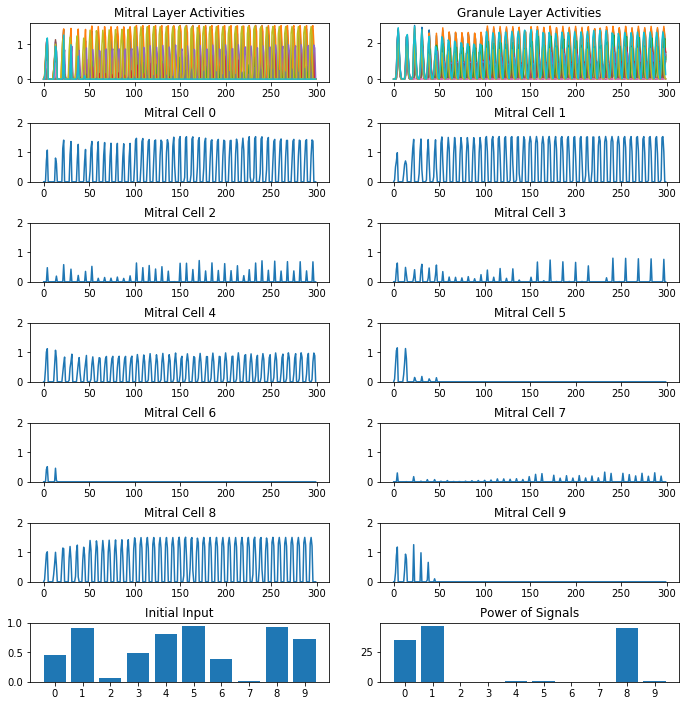

In [6]:
# init
I = np.random.rand(m_size) # input
show(*sim_olf(I.copy()), I)

In [7]:
gus_size = 4

def mapping(x, eap=False):
    """ a mapping from olf values to gus values
    """
    li = [0, 1, 3, 6, 10]
    out = np.array([x[li[i] : li[i+1]].sum() for i in range(4)])
    if eap: print(out)
    return out / np.linalg.norm(out)

In [8]:
def sim2(eta):
    """ Run the simulation of the associative network
    
        Parameter
        ----------
        eta: float
            learning rate
    """
    I = np.random.rand(10000, m_size)
    
    # make difference
    scales = np.array([[2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                      [0.5, 2, 2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                      [0.5, 0.5, 0.5, 2, 2, 2, 0.5, 0.5, 0.5, 0.5],
                      [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2, 2, 2, 2]])
    for i in range(4):
        start, end = i * 2500, (i + 1) * 2500
        I[start : end] = \
            np.apply_along_axis(lambda v: v * scales[i], 1, I[start:end])
    
    Y = np.zeros((10000, gus_size))
    WI = np.zeros((m_size, gus_size)) # connections from interneurons to gustatary neurons
    
    for i in range(10000):
        Y[i] = mapping(I[i])
        
        WI = WI + eta * (np.outer(I[i], Y[i]) - WI @ np.triu(np.outer(Y[i], Y[i])))
        WI = np.apply_along_axis(lambda v: v - 4e-6 / (I[i] + 0.001), 0, WI)
    
    return WI

In [9]:
WI = sim2(0.001)

In [10]:
t = 0
for i in range(30):
    I = np.random.rand(m_size)
    p = sim_olf(I)[-1]
#     print('Processed olf: ', p)
    ideal = mapping(p, False)
#     print('ideal: ', ideal)
    out = p @ WI
    out /= np.linalg.norm(out)
#     print('actual: ', out)
    mse = ((out - ideal)**2).mean()
    t += mse
#     print('MSE: ', mse)
#     print('W: \n', WI)
    
print(t / 30)

0.017000487002112763
